In [1]:
import cv2
import numpy as np
import pandas as pd
import numba
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [107]:
model = 0     # spin model - 0; schooling model - 1
mod = 'NN' if model == 0 else 'SPP'
suffix = '_model' if model == 0 else '_simulation'
nPosts = 2    # spin model: nPosts=2/3 => total_agents = 12/120; temperature = 0.03/0.0;
df = pd.read_csv("/Users/vivekhsridhar/Documents/Work/Results/decision_geometry/Data/Theory/" + mod + "/geometry" + str(nPosts) + ".csv")
df.head()

,replicate,time,x,y,angular_disagreement,relative_direction,dir_x,dir_y,sim_id
0,0,10,9.16405,499.322,61.0669,27.4995,0.473910,-0.024555,0
1,0,20,14.05430,499.033,61.6504,26.2095,0.529668,-0.041855,0
2,0,30,19.54410,498.547,62.3173,27.6844,0.570756,-0.033178,0
3,0,40,25.27120,498.164,63.0270,28.9406,0.582842,-0.024280,0
4,0,50,31.35920,497.793,63.7974,27.9595,0.637064,-0.041334,0


In [108]:
xs = np.array(df[' x'] / 100)
ys = np.array((df[' y'] - 500) / 100)

if nPosts == 2:
    post0_x = 5.0*np.cos(np.pi/6)
    post0_y = -5.0*np.sin(np.pi/6)

    post1_x = 5.0*np.cos(np.pi/6)
    post1_y = 5.0*np.sin(np.pi/6)
else:
    post0_x = 5.0*np.cos(2*np.pi/9)
    post0_y = -5.0*np.sin(2*np.pi/9)

    post1_x = 5.0
    post1_y = 0.0
    
    post2_x = 5.0*np.cos(2*np.pi/9)
    post2_y = 5.0*np.sin(2*np.pi/9)

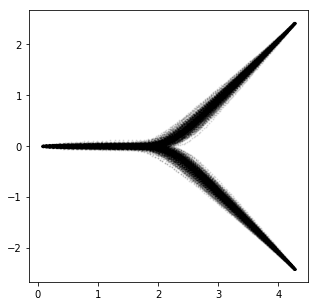

In [109]:
plt.figure(figsize=(5,5))
plt.scatter(xs, ys, c='black', s=1, alpha=0.1)
plt.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/trajectories_' + str(nPosts) + suffix + '.png', format='png', dpi=300)

In [110]:
nbins = 500
peak_threshold = 0.95


def density_map(x, y, stats=True):
    if nPosts == 2:
        blur = (11, 11) if stats == True else (71, 71)
        r = [[0, post0_x], [post0_y, post1_y]]
    else:
        blur = (11, 11) if stats == True else (71, 71)
        r = [[0, post1_x], [post0_y, post2_y]]
    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)

    if nPosts == 2:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))
    else:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))

    for i in range(0, nbins):
        max_val = np.nanmax(tmp_img[:, i])
        tmp_img[:, i] = tmp_img[:, i] / max_val if max_val > 0 else tmp_img[:, i]

    return tmp_img

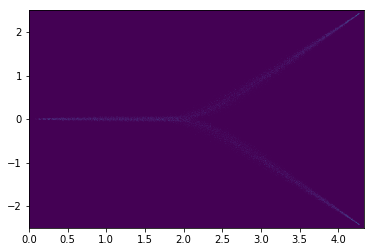

In [111]:
img = density_map(xs, ys, stats=False)

if nPosts == 2:
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
else:
    x_peaks = np.where(img > peak_threshold)[1] * post1_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

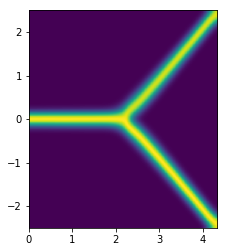

In [112]:
if nPosts == 2:
    plt.imshow(img, extent=[0, post0_x, post0_y, post1_y])
else:
    plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])

plt.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/' + str(nPosts) + '_post_bifurcation_tracks' + suffix + '.png', format='png', dpi=300)

### Identify bifurcation point using a piecewise phase-transition function

#### Get first bifurcation point
Once you have this, you can draw a line segment bisecting the angle between the point and two targets. This will be the line about which you symmetrise to get the second bifurcation point

In [113]:
def fitfunc(x, p, q):
    if x < p:
        return 0
    else:
        return np.abs(x - p) ** q

def fitline(x, p, q):
    return p*x + q

def fitfunc_vec_self(x, p, q):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q)
    return y

def fitline_vec_self(x, p, q):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitline(x[i], p, q)
    return y

0
10
20
30
40
50
60
70
80
90


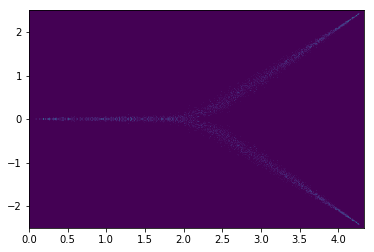

In [114]:
n_iters = 100
params1 = np.zeros((n_iters, 2))

if nPosts == 2:
    for i in range(n_iters):
        x_fit = []
        y_fit = []

        indices = np.random.choice(len(xs), size=10000, replace=True)
        x_sub = np.concatenate((xs[indices], xs[indices]))
        y_sub = np.concatenate((ys[indices], -ys[indices]))

        tmp_img = density_map(x_sub, y_sub, stats=True)
        x_fit = np.where(tmp_img > peak_threshold)[1] * post0_x / nbins
        y_fit = (
            np.where(tmp_img > peak_threshold)[0] * (post0_y - post1_y) / nbins
            + post1_y
        )

        x_fit = x_fit
        y_fit = np.abs(y_fit)

        fit_params, pcov = curve_fit(
            fitfunc_vec_self, x_fit, y_fit, p0=[3, 1], maxfev=10000
        )
        params1[i, :] = fit_params

        if i % 10 == 0:
            print(i)
else:
    xs1 = xs[np.where(xs < 3.)[0]]
    ys1 = ys[np.where(xs < 3.)[0]]

    for i in range(n_iters):
        x_fit = []
        y_fit = []

        indices = np.random.choice(len(xs1), size=10000, replace=True)
        x_sub = np.concatenate((xs1[indices], xs1[indices]))
        y_sub = np.concatenate((ys1[indices], -ys1[indices]))

        tmp_img = density_map(x_sub, y_sub, stats=True)
        x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
        y_fit = (
            np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins
            + post2_y
        )

        x_fit = x_fit
        y_fit = np.abs(y_fit)

        fit_params, pcov = curve_fit(
            fitfunc_vec_self, x_fit, y_fit, p0=[1, 1], maxfev=10000
        )
        params1[i, :] = fit_params

        if i % 10 == 0:
            print(i)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in power


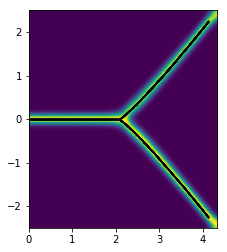

In [115]:
if nPosts == 2:
    plt.imshow(img**2, extent=[0, post0_x, post0_y, post1_y])
else:
    plt.imshow(img**2, extent=[0, post1_x, post0_y, post2_y])

for i in range(n_iters):
    parameters = params1[i]
    step_len = 0.01

    x1 = np.arange(step_len, parameters[0], step_len)
    y1 = np.zeros(len(x1))

    x = (
        np.arange(parameters[0], post0_x-0.2, step_len)
        if nPosts == 2
        else np.arange(parameters[0], 3., step_len)
    )
    x2 = np.concatenate((x, x))
    y2 = np.concatenate(
        ((x - parameters[0]) ** parameters[1], -(x - parameters[0]) ** parameters[1])
    )
        
    if nPosts != 2:
        bisector_xs = [np.median(params1, axis=0)[0], 4.5]
        bisector_ys = [
            0,
            np.tan(np.arctan2(post2_y, post2_x - np.min(params1, axis=0)[0]) / 2)
            * (post2_x - np.min(params1, axis=0)[0]),
        ]

    plt.scatter(x1, y1, c="black", s=1, alpha=0.01)
    plt.scatter(x2, y2, c="black", s=1, alpha=0.01)


lx = x
ly = (x - np.median(params1, axis=0)[0]) ** np.median(params1, axis=0)[1]
lx = lx[np.where(np.isnan(ly) == False)[0]]
ly = ly[np.where(np.isnan(ly) == False)[0]]
    
if nPosts == 2:
    plt.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/' + str(nPosts) + '_post' + suffix + '_quantified.png', format='png', dpi=300)

In [116]:
if nPosts == 2:
    print(
        "The bifurcation occurs at an angle",
        2 * np.arctan2(post1_y, post1_x - np.median(params1, axis=0)[0]) * 180 / np.pi,
    )
else:
    print(
        "The first bifurcation occurs at an angle",
        2 * np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) * 180 / np.pi,
    )

The bifurcation occurs at an angle 95.81746742129235


#### Get the second bifurcation point
For this, you must center the trajectories about the bifurcation point, get a new heatmap and rotate this by the angle of the bisector line

In [93]:
# center points about the first bifurcation
cxs = xs - np.median(params1, axis=0)[0]
cys = ys

cpost0_x = post0_x - np.median(params1, axis=0)[0]
cpost1_x = post1_x - np.median(params1, axis=0)[0]
cpost2_x = post2_x - np.median(params1, axis=0)[0]

In [94]:
@numba.njit(fastmath=True, parallel=True)
def parallel_rotate(xy, rmat):
    out = np.zeros(xy.shape)
    for idx in numba.prange(xy.shape[0]):
        out[idx] = np.dot(rmat[idx], xy[idx])
    return out

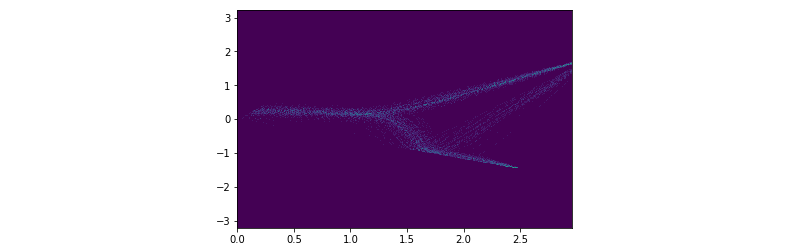

In [95]:
# clip all points to the left of and below 0 and points beyond post centers
ccxs = cxs[
    np.where(cxs > 0)[0]
]  # | (cys > 0) | (cxs > cpost1_x) | (cys < post0_y) | (cys > post2_y))[0]]
ccys = cys[np.where(cxs > 0)[0]]
ccxs = ccxs[np.where(ccys > 0)[0]]
ccys = ccys[np.where(ccys > 0)[0]]

# idxs = np.where((txs > 0) & (txs < post1_x) & (tys > post0_y) & (tys < post2_y))[0]
# txs = txs[idxs]
# tys = tys[idxs]

# cpost0 = np.array([cpost0_x,post0_y]).reshape(-1,2)
# cpost1 = np.array([cpost1_x,post1_y]).reshape(-1,2)
# cpost2 = np.array([cpost2_x,post2_y]).reshape(-1,2)

xy = np.concatenate((ccxs.reshape(-1, 1), ccys.reshape(-1, 1)), axis=1)
angle = np.full(
    ccxs.shape, np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) / 2
)
# angle = np.full(ccxs.shape, np.arctan2(line_params[0], 1.))
rmat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T
rx, ry = parallel_rotate(xy, rmat).T

# bry = np.abs(ry)
# xy = np.concatenate((rx.reshape(-1,1),bry.reshape(-1,1)), axis=1)
# angle = np.full(rx.shape, -np.arctan2(post2_y,post2_x-np.median(params1, axis=0)[0])/2)
# rmat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T
# brx, bry = parallel_rotate(xy, rmat).T

# cposts = np.concatenate((cpost1, cpost2))
# angle2 = np.full((cposts.shape[0],), np.arctan2(post2_y,post2_x-np.median(params, axis=0)[0])/2)
# rmat2 = np.array([[np.cos(angle2), -np.sin(angle2)], [np.sin(angle2), np.cos(angle2)]]).T
# rpostsx, rpostsy = parallel_rotate(cposts, rmat2).T

blur = (101, 101) if nPosts == 2 else (51,51)

r1 = [[0, post1_x], [post0_y, post2_y]]
r2 = [
    [-np.median(params1, axis=0)[0], post1_x - np.median(params1, axis=0)[0]],
    [post0_y, post2_y],
]
r3 = [[0, post1_x - np.median(params1, axis=0)[0]], [post0_y, post2_y]]

h1, xedge, yedge, image = plt.hist2d(xs, ys, bins=nbins, normed=True, range=r1)
h2, xedge, yedge, image = plt.hist2d(cxs, cys, bins=nbins, normed=True, range=r2)
h3, xedge, yedge, image = plt.hist2d(
    ccxs, ccys, bins=nbins, normed=True, range=r3
)
h4, xedge, yedge, image = plt.hist2d(rx, ry, bins=nbins, normed=True, range=r3)

tmp_img1 = np.flipud(np.rot90(cv2.GaussianBlur(h1, blur, 0)))
tmp_img2 = np.flipud(np.rot90(cv2.GaussianBlur(h2, blur, 0)))
tmp_img3 = np.flipud(np.rot90(cv2.GaussianBlur(h3, blur, 0)))
tmp_img4 = np.flipud(np.rot90(cv2.GaussianBlur(h4, blur, 0)))

for i in range(0, nbins):
    max_val = np.max(tmp_img1[:, i])
    tmp_img1[:, i] = tmp_img1[:, i] / max_val
    max_val = np.max(tmp_img2[:, i])
    tmp_img2[:, i] = tmp_img2[:, i] / max_val
    max_val = np.max(tmp_img3[:, i])
    tmp_img3[:, i] = tmp_img3[:, i] / max_val
    max_val = np.max(tmp_img4[:, i])
    tmp_img4[:, i] = tmp_img4[:, i] / max_val

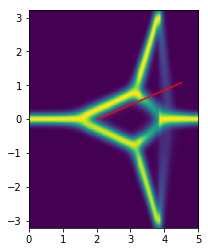

In [96]:
plt.imshow(tmp_img1, extent=[r1[0][0], r1[0][1], r1[1][0], r1[1][1]])
plt.plot(bisector_xs, bisector_ys, c="red")

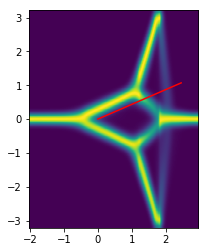

In [97]:
plt.imshow(tmp_img2, extent=[r2[0][0], r2[0][1], r2[1][0], r2[1][1]])
plt.plot(bisector_xs - np.median(params1, axis=0)[0], bisector_ys, c="red")

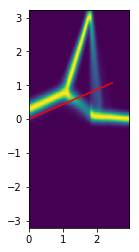

In [98]:
plt.imshow(np.flipud(tmp_img3), extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])
plt.plot(bisector_xs - np.median(params1, axis=0)[0], bisector_ys, c="red")

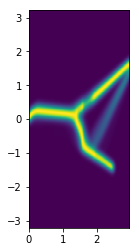

In [99]:
plt.imshow(np.flipud(tmp_img4), extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])

0
10
20
30
40
50
60
70
80
90


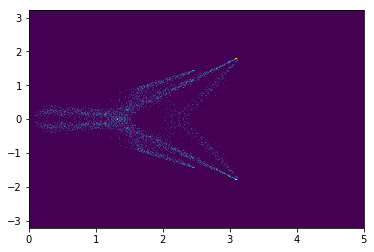

In [100]:
params2 = np.zeros((n_iters, 2))

for i in range(n_iters):
    x_fit = []
    y_fit = []

    indices = np.random.choice(len(rx), size=10000, replace=True)
    x_sub = np.concatenate((rx[indices], rx[indices]))
    y_sub = np.concatenate((ry[indices], -ry[indices]))

    tmp_img = density_map(x_sub, y_sub, stats=True)
    x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
    y_fit = (
        np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y
    )

    x_fit = x_fit
    y_fit = np.abs(y_fit)

    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=[1, 1], maxfev=10000
    )
    params2[i, :] = fit_params

    if i % 10 == 0:
        print(i)

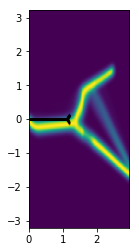

In [101]:
plt.imshow(tmp_img4, extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])

for i in range(n_iters):
    parameters = params2[i]
    step_len = 0.01

    x1 = np.arange(step_len, parameters[0], step_len)
    y1 = np.zeros(len(x1))

    x = (
        np.arange(parameters[0], post0_x, step_len)
        if nPosts == 2
        else np.arange(parameters[0], 1.2, step_len)
    )
    x2 = np.concatenate((x, x))
    y2 = np.concatenate(
        ((x - parameters[0]) ** parameters[1], -(x - parameters[0]) ** parameters[1])
    )
    
    plt.scatter(x1, y1, c="black", s=1, alpha=0.01)
    plt.scatter(x2, y2, c="black", s=1, alpha=0.01)
    # mf.pb.plt.vlines(np.median(params1, axis=0)[0], ymin=post0_y, ymax=post2_y, color='white', linestyles='dashed')

In [102]:
bif2 = np.array([np.median(params2, axis=0)[0], 0]).reshape(1, -1)
ang = angle[0]
rmat1 = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]]).T
bif2 = parallel_rotate(bif2, rmat).T
bif2[0] += np.median(params1, axis=0)[0]

In [103]:
print(
    "The second bifurcation occurs at angle",
    (
        (
            np.arctan2(post2_y - bif2[1], post2_x - bif2[0])
            - np.arctan2(bif2[1] - post1_y, post1_x - bif2[0])
        )
        * 180
        / np.pi
    )[0],
)

The second bifurcation occurs at angle 93.7149646031379


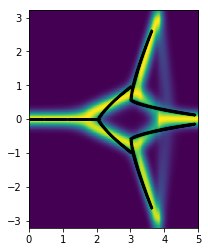

In [104]:
plt.imshow(img, extent=[0, post1_x, post0_y, post2_y])

for i in range(n_iters):
    parameters = params2[i]
    step_len = 0.01

    x1 = np.arange(step_len, parameters[0], step_len)
    y1 = np.zeros(len(x1))
    bcxy1 = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1)), axis=1)
    ang1 = np.full(
        x1.shape, -np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) / 2
    )
    rmat1 = np.array([[np.cos(ang1), -np.sin(ang1)], [np.sin(ang1), np.cos(ang1)]]).T
    bcx1, bcy1 = parallel_rotate(bcxy1, rmat1).T
    bx1 = bcx1 + np.median(params1, axis=0)[0]

    x = (
        np.arange(parameters[0], post0_x, step_len)
        if nPosts == 2
        else np.arange(parameters[0], 2.7, step_len)
    )
    x2 = np.concatenate((x, x))
    y2 = np.concatenate(
        ((x - parameters[0]) ** parameters[1], -(x - parameters[0]) ** parameters[1])
    )
    bcxy2 = np.concatenate((x2.reshape(-1, 1), y2.reshape(-1, 1)), axis=1)
    ang2 = np.full(
        x2.shape, -np.arctan2(post2_y, post2_x - np.median(params1, axis=0)[0]) / 2
    )
    rmat2 = np.array([[np.cos(ang2), -np.sin(ang2)], [np.sin(ang2), np.cos(ang2)]]).T
    bcx2, bcy2 = parallel_rotate(bcxy2, rmat2).T
    bx2 = bcx2 + np.median(params1, axis=0)[0]

    bx2 = np.concatenate((bx2, bx2))
    bcy2 = np.concatenate((bcy2, -bcy2))
    
    bcy2 = bcy2[np.where(bx2 < post1_x-0.1)[0]]
    bx2 = bx2[np.where(bx2 < post1_x-0.1)[0]]
    
    bx2 = bx2[np.where(np.abs(bcy2) < post2_y-0.1)[0]]
    bcy2 = bcy2[np.where(np.abs(bcy2) < post2_y-0.1)[0]]

    # plt.scatter(bx1,bcy1, c='black', s=1, alpha=0.01)
    plt.scatter(bx2, bcy2, c="black", s=1, alpha=0.01)

    parameters = params1[i]
    step_len = 0.01

    x1 = np.arange(step_len, parameters[0], step_len)
    y1 = np.zeros(len(x1))

    x = (
        np.arange(parameters[0], post0_x, step_len)
        if nPosts == 2
        else np.arange(parameters[0], np.max(bx1), step_len)
    )
    x2 = np.concatenate((x, x))
    y2 = np.concatenate(
        ((x - parameters[0]) ** parameters[1], -(x - parameters[0]) ** parameters[1])
    )

    plt.scatter(x1, y1, c="black", s=1, alpha=0.01)
    plt.scatter(x2, y2, c="black", s=1, alpha=0.01)
    
plt.savefig('/Users/vivekhsridhar/Documents/Code/Python/fly-matrix/figures/' + str(nPosts) + '_post' + suffix + '_quantified.png', format='png', dpi=300)